# Deepfake detection using GAN

In [269]:
# Imports
import numpy as np
import random
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

Controlling seeds to control reproducability.

In [271]:
# Root directory for dataset
dataroot = "sample_set/real"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [272]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = tv.datasets.ImageFolder(
    root=dataroot,
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)


datasetfake = tv.datasets.ImageFolder(
    root="sample_set/fake",
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

dataloaderfake = torch.utils.data.DataLoader(
    datasetfake, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [273]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [274]:
class Discriminator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [275]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = torch.nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [276]:
# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [277]:
# Training Loop

# Lists to keep track of progress
img_list = []
D_losses = []
# For each epoch
for epoch in tqdm(num_epochs):
    itfake = iter(dataloaderfake)
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        fake_cpu = next(itfake)[0].to(device)
        b_size = fake_cpu.size(0)
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with D
        output = netD(fake_cpu).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Save Losses for plotting later
        D_losses.append(errD.item())

Starting Training Loop...
[0.0][(0, 4)]	Loss_D: (3, 4)	D(x): 0.1671	D(G(z)): 0.31745728850364685
[0.06666666666666667][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9972	D(G(z)): 0.00181625597178936
[0.13333333333333333][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9996	D(G(z)): 0.00039834066410548985
[0.2][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9997	D(G(z)): 0.0002945365267805755
[0.26666666666666666][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9997	D(G(z)): 0.0003418669512029737
[0.3333333333333333][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9998	D(G(z)): 0.0001977791980607435
[0.4][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9999	D(G(z)): 0.00018811773043125868
[0.4666666666666667][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9999	D(G(z)): 0.00020387204131111503
[0.5333333333333333][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9999	D(G(z)): 0.00028383772587403655
[0.6][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9999	D(G(z)): 0.00015184268704615533
[0.6666666666666666][(0, 4)]	Loss_D: (0, 4)	D(x): 0.9999	D(G(z)): 0.00011443744733696803
[0.7333333333333333][(0, 4)]	Loss_D: (0, 4)	D(x): 1.0	D(G(z))

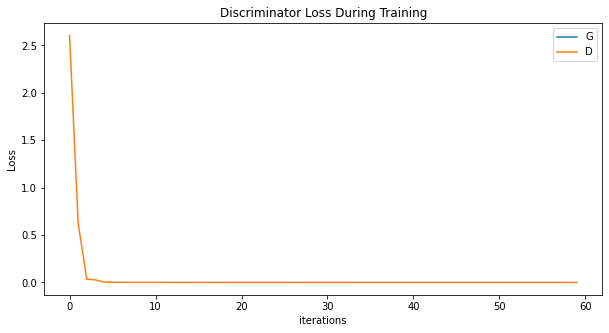

In [278]:
plt.figure(figsize=(10, 5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [279]:
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [285]:
def predict_folder(path):
    videos = tv.datasets.ImageFolder(
        root=path,
        transform=tv.transforms.Compose(
            [
                tv.transforms.Resize(image_size),
                tv.transforms.CenterCrop(image_size),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    for ind, val in videos.class_to_idx.items():
        low = math.inf
        high = -1
        for i, ele in enumerate(videos.imgs):
            _, idx = ele
            if idx == val:
                if i < low:
                    low = i
                if i > high:
                    high = i
        video = torch.utils.data.Subset(videos, range(low, high))
        results = []
        for frame in video:
            frame = frame[0]
            frame = frame.view(1, *frame.shape)
            results.append(netD(frame).view(-1).item())
        print(ind, np.mean(results))


In [286]:
predict_folder('sample_set/real')

eggbjzxnmg.mp4 0.993619021166254
eudeqjhdfd.mp4 0.991337468781447


In [287]:
predict_folder('sample_set/fake')

etohcvnzbj.mp4 0.009484085282696298
eukvucdetx.mp4 0.0019102661750098103
